In [4]:
import os
from IPython import display
import matplotlib.pyplot as plt
import librosa
import numpy as np
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
from timeit import default_timer as timer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import CategoricalCrossentropy

In [5]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

In [6]:
# Loading data

def load_data(ds):
    root = './features/yamnet_embeddings'

    if ds == 'tess':
        X = np.load(f'{root}/Tess_X.npy')
        y = np.load(f'{root}/Tess_y.npy')
    elif ds == 'ravdess':
        X = np.load(f'{root}/Ravdess_X.npy')
        y = np.load(f'{root}/Ravdess_y.npy')
    elif ds == 'savee':
        X = np.load(f'{root}/Savee_X.npy')
        y = np.load(f'{root}/Savee_y.npy')
    elif ds == 'crema':
        X = np.load(f'{root}/Crema_X.npy')
        y = np.load(f'{root}/Crema_y.npy')
    elif ds == 'all':
        X = np.load(f'{root}/All_X.npy')
        y = np.load(f'{root}/All_y.npy')
    else:
        raise ValueError('Invalid dataset')
        
    return X, y

In [7]:
def evaluationReport(hist, model, batch_size, encoder, train_data, train_label, test_data, test_label, classes):
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    
    plt.plot(hist.history['accuracy'], label='train accuracy')
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
    
    labels = classes
    

    print('\nEvaluation')
    print('----------------------------')
    train_loss, train_acc = model.evaluate(train_data, train_label, verbose=1, batch_size=batch_size)
    test_loss, test_acc = model.evaluate(test_data, test_label, verbose=1, batch_size=batch_size)
    sns.barplot(x=['train', 'test'], y=[train_acc, test_acc], palette=['red', 'blue']).set_title('Training vs Testing Accuracy')
    plt.show()
    sns.barplot(x=['train', 'test'], y=[train_loss, test_loss], palette=['red', 'blue']).set_title('Training vs Testing Loss')
    plt.show()
    
    
    # Classification reprot
    preds = model.predict(test_data)
#     y_pred = np.argmax(preds, axis=1)
    y_pred = encoder.inverse_transform(preds)
    test_label = encoder.inverse_transform(test_label)
    print('\nClassification Report')
    print('----------------------------')
    print(classification_report(test_label, y_pred))

    # Confusion Matrix
    print('\nConfusion Matrix')
    print('----------------------------')
    cm = confusion_matrix(test_label, y_pred)
    fig, ax= plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels);
    ax.yaxis.set_ticklabels(labels);

In [8]:
from sklearn.model_selection import train_test_split

def split_df(data, label, ratio_train=0.7, ratio_val=0.15, ratio_test=0.15):
    if ratio_train + ratio_val + ratio_test != 1:
        raise ValueError('Train, validation and test ratios must sum to 1')

    # Produces test split.
    remaining_data,  test_data, remaining_label, test_label = train_test_split(
        data, label, test_size=ratio_test, stratify=label, shuffle=True)

    # Adjusts val ratio, w.r.t. remaining dataset.
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining

    # Produces train and val splits.
    train_data, val_data, train_label, val_label = train_test_split(
        remaining_data, remaining_label,
        test_size=ratio_val_adjusted,
        stratify=remaining_label, shuffle=True
    )
    
    return train_data, train_label, val_data, val_label, test_data, test_label

In [9]:
# train_data = np.expand_dims(train_data, axis=2)
# val_data = np.expand_dims(val_data, axis=2)
# test_data = np.expand_dims(test_data, axis=2)

# train_data.shape, train_label.shape, val_data.shape, val_label.shape, test_data.shape, test_label.shape

In [10]:
def simple_dense_preprocess(train_label, val_label, test_label):
    """
        Encodes the labels using OneHotEncoder
    """
    
    train_label = train_label.reshape(-1, 1)
    val_label = val_label.reshape(-1, 1)
    test_label = test_label.reshape(-1, 1)
    
    encoder = OneHotEncoder()
    
    train_label = encoder.fit_transform(train_label).toarray()
    val_label = encoder.transform(val_label).toarray()
    test_label = encoder.transform(test_label).toarray()
    
    return encoder, train_label, val_label, test_label

In [11]:
def get_es(patience=20):
    return EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1)

def get_opt(opt='adam', lr=0):
    if opt == 'adam':
        if lr != 0:
            return Adam(learning_rate=lr)
        return Adam()
    elif opt == 'adamax':
        if lr != 0:
            return Adamax(learning_rate=lr)
        return Adamax()
    else:
        RaiseError('Invalid optimizer')

def get_lr(factor=0.5, patience=5):
    return ReduceLROnPlateau(
    monitor="val_loss",
    factor=factor,
    patience=patience,
    cooldown=0,
    verbose=1,
    mode="min",
    min_delta=0.0001,
    min_lr=1e-13
    )

def get_loss():
    return tf.keras.losses.CategoricalCrossentropy()

In [12]:
# import math

# def get_lr_callback(mode='exp', batch_size=64, epochs=30, plot=False, lr_start=BASE_LR):
#     """adapted from @cdeotte"""
#     lr = BASE_LR
#     lr_max = BASE_LR # max lr - will be multiplied by batch_size
#     lr_min = 3e-8 # min lr
#     lr_ramp_ep = 0 # warming up epochs
#     lr_sus_ep = 0 # sustain epochs lr after warming up
#     lr_decay = 0.8 # decay rate

#     def lrfn(epoch):
#         if epoch < lr_ramp_ep:
#             lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

#         elif epoch < lr_ramp_ep + lr_sus_ep:
#             lr = lr_max

#         elif mode == 'exp':
#             lr = (lr_max - lr_min) * lr_decay**(epoch - \
#                   lr_ramp_ep - lr_sus_ep) + lr_min

#         elif mode == 'step':
#             lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

#         elif mode == 'cosine':
#             decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
#             decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
#             phase = math.pi * decay_epoch_index / decay_total_epochs
#             cosine_decay = 0.5 * (1 + math.cos(phase))
#             lr = (lr_max - lr_min) * cosine_decay + lr_min
#         return lr

#     if plot:
#         plt.figure(figsize=(10, 5))
#         plt.plot(
#             np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
#         plt.xlabel('epoch')
#         plt.ylabel('learnig rate')
#         plt.title('Learning Rate Scheduler')
#     return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [13]:
# lr_v2 = get_lr_callback(mode='cosine',epochs=EPOCH,plot=True,batch_size=BATCH_SIZE)

In [14]:
def get_data(ds, preprocess):
    X, y = load_data(ds)
    train_data, train_label, val_data, val_label, test_data, test_label = split_df(X, y)
    encoder, train_label, val_label, test_label = preprocess(train_label, val_label, test_label)
    return train_data, train_label, val_data, val_label, test_data, test_label, encoder

In [15]:
def train_and_evaluate(CFG):
    
    train_data, train_label, val_data, val_label, test_data, test_label, enc = get_data(CFG.ds, CFG.preprocess)
    
    model = CFG.get_model()
    print(model.summary())

    print(f'Training {CFG.model_name}_{CFG.ds}...')
    start = timer()
    history = model.fit(
        x=train_data,
        y=train_label,
        epochs=CFG.EPOCH,
        validation_data=(val_data, val_label),
        batch_size=CFG.BATCH_SIZE,
        callbacks=CFG.callbacks,
        verbose=0
    )
    end = timer()
    print(f'\nDone training {CFG.model_name}_{CFG.ds} in', end - start, 'seconds')
    print('--------------------------------------------------\n')
    
    print(f'\nEvaluating {CFG.model_name}_{CFG.ds} on test set...')
    print('--------------------------------------------------\n')
    evaluationReport(history, model, CFG.BATCH_SIZE, enc, train_data, train_label, test_data, test_label, CFG.classes)

In [16]:
train_data, train_label, val_data, val_label, test_data, test_label, encoder = get_data('tess', simple_dense_preprocess)
EPOCH = 25
BATCH_SIZE = 32

In [18]:
yamnet_model.summary()

AttributeError: '_UserObject' object has no attribute 'summary'

In [17]:
history = yamnet_model.fit(
    x=train_data,
    y=train_label,
    epochs=EPOCH,
    validation_data=(val_data, val_label),
    batch_size=BATCH_SIZE,
    callbacks=[get_es(), get_lr()]
)

AttributeError: '_UserObject' object has no attribute 'fit'

# TESS

In [142]:
class TESS_CFG:
    ds = 'tess'
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    BASE_LR = 5e-4
    EPOCH = 20000
    BATCH_SIZE = 32
    
    model_name = 'simple_dense'
    preprocess = simple_dense_preprocess # Needs to be change when model changes

    opt = get_opt('adam', BASE_LR)
    es = get_es()
    lr = get_lr(factor=0.5, patience=3)
    loss = get_loss()

    callbacks = [
        es,
        lr
    ]
    
    def get_model():
        model = tf.keras.Sequential([
            # Input layer, don't change
            tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
            
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(0.25),
            
            # Output layer, don't change
            tf.keras.layers.Dense(len(TESS_CFG.classes), activation='softmax')
        ], name=f'{TESS_CFG.model_name}_{TESS_CFG.ds}')
        
        model.compile(loss=TESS_CFG.loss,
                     optimizer=TESS_CFG.opt,
                     metrics=['accuracy']
        )
        
        return model

Done preprocessing tess in 0.04914172200005851
Model: "simple_dense_tess"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_81 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_83 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
de

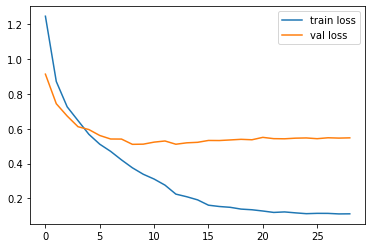

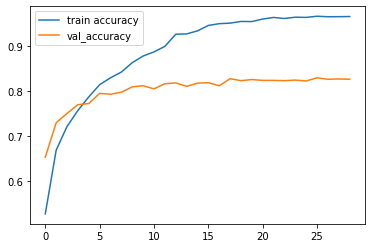


Evaluation
----------------------------
50/50 [==============================] - 0s 2ms/step - loss: 0.5127 - accuracy: 0.8079


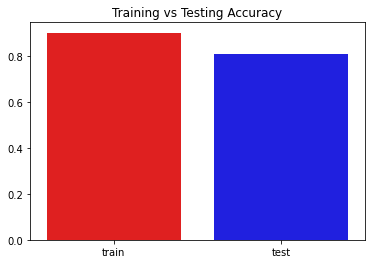

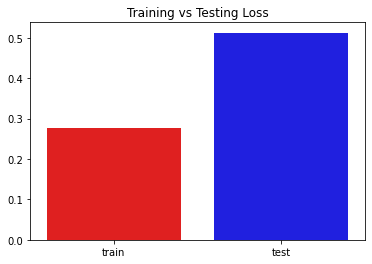


Classification Report
----------------------------
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       204
           1       0.76      0.89      0.82       275
           2       0.85      0.91      0.88       177
           3       0.72      0.72      0.72       218
           4       0.91      0.81      0.86       230
           5       0.82      0.82      0.82       268
           6       0.81      0.73      0.77       216

    accuracy                           0.81      1588
   macro avg       0.81      0.81      0.81      1588
weighted avg       0.81      0.81      0.81      1588


Confusion Matrix
----------------------------


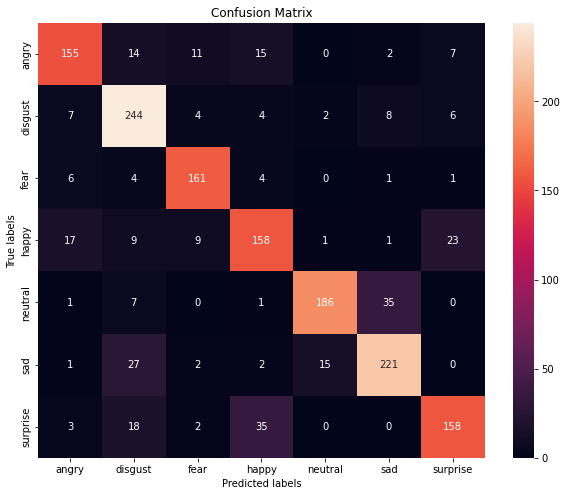

In [132]:
train_and_evaluate(TESS_CFG)

# RAVDESS

In [147]:
class RAVDESS_CFG:
    ds = 'ravdess'
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    BASE_LR = 1e-4
    EPOCH = 20000
    BATCH_SIZE = 32
    model_name = 'simple_dense'
    preprocess = simple_dense_preprocess

    opt = get_opt('adamax', BASE_LR)
    es = get_es()
    lr = get_lr(factor=0.5, patience=3)
    loss = get_loss()

    callbacks = [
        es,
        lr
    ]
    
    def get_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
            
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Dense(len(RAVDESS_CFG.classes), activation='softmax')
        ], name=f'{RAVDESS_CFG.model_name}_{RAVDESS_CFG.ds}')
        
        model.compile(loss=RAVDESS_CFG.loss,
                     optimizer=RAVDESS_CFG.opt,
                     metrics=['accuracy']
        )
        
        return model

Model: "simple_dense_ravdess"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_101 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_103 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 7)        

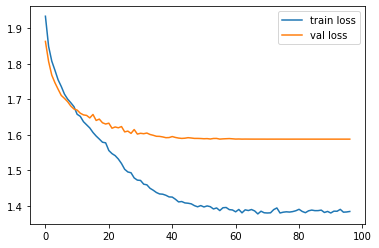

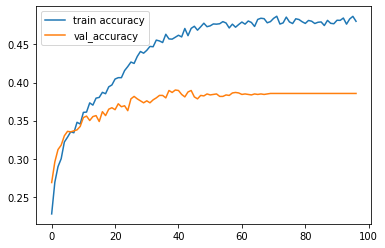


Evaluation
----------------------------
49/49 [==============================] - 0s 2ms/step - loss: 1.6200 - accuracy: 0.3895


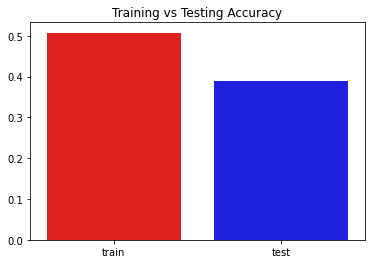

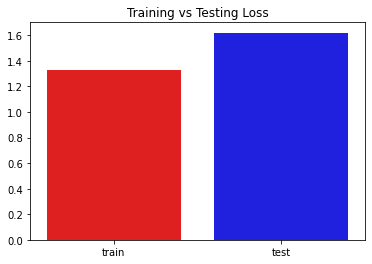


Classification Report
----------------------------
              precision    recall  f1-score   support

           0       0.47      0.41      0.44       217
           1       0.37      0.29      0.32       221
           2       0.37      0.40      0.38       199
           3       0.26      0.18      0.21       203
           4       0.40      0.79      0.53       309
           5       0.26      0.11      0.15       205
           6       0.51      0.35      0.42       194

    accuracy                           0.39      1548
   macro avg       0.38      0.36      0.35      1548
weighted avg       0.38      0.39      0.36      1548


Confusion Matrix
----------------------------


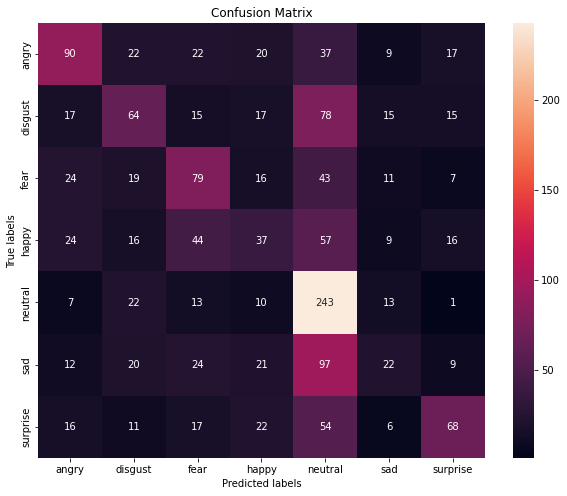

In [148]:
train_and_evaluate(RAVDESS_CFG)

# SAVEE

In [110]:
class SAVEE_CFG:
    ds = 'savee'
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    BASE_LR = 1e-4
    EPOCH = 20000
    BATCH_SIZE = 32
    model_name = 'simple_dense'
    preprocess = simple_dense_preprocess

    opt = get_opt('adamax', SAVEE_CFG.BASE_LR)
    es = get_es()
    lr = get_lr(factor=0.5, patience=3)
    loss = get_loss()

    callbacks = [
        es,
        lr
    ]
    
    def get_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(len(SAVEE_CFG.classes), activation='softmax')
        ], name=f'{SAVEE_CFG.model_name}_{SAVEE_CFG.ds}')
        
        model.compile(loss=SAVEE_CFG.loss,
                     optimizer=SAVEE_CFG.opt,
                     metrics=['accuracy']
        )
        
        return model

In [ ]:
train_and_evaluate(SAVEE_CFG)

# CREMA

In [157]:
class CREMA_CFG:
    ds = 'crema'
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
    BASE_LR = 1e-4
    EPOCH = 20000
    BATCH_SIZE = 32
    model_name = 'simple_dense'
    preprocess = simple_dense_preprocess

    opt = get_opt('adamax', BASE_LR)
    es = get_es()
    lr = get_lr(factor=0.5, patience=3)
    loss = get_loss()

    callbacks = [
        es,
        lr
    ]
    
    def get_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
            
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Dense(len(CREMA_CFG.classes), activation='softmax')
        ], name=f'{CREMA_CFG.model_name}_{CREMA_CFG.ds}')
        
        model.compile(loss=CREMA_CFG.loss,
                     optimizer=CREMA_CFG.opt,
                     metrics=['accuracy']
        )
        
        return model

Model: "simple_dense_crema"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 128)               131200    
_________________________________________________________________
dense_117 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 6)                 390       
Total params: 139,846
Trainable params: 139,846
Non-trainable params: 0
_________________________________________________________________
None
Training simple_dense_crema...

Epoch 00049: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00066: ReduceLROnPlateau reducing l

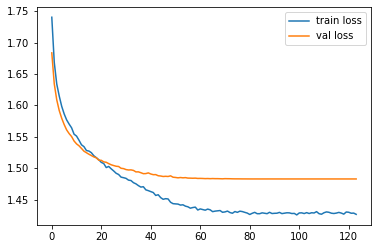

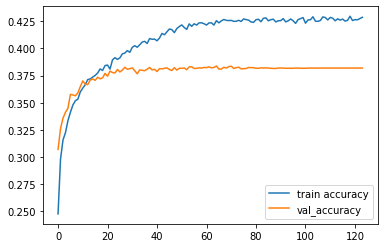


Evaluation
----------------------------
167/167 [==============================] - 0s 2ms/step - loss: 1.4900 - accuracy: 0.3940


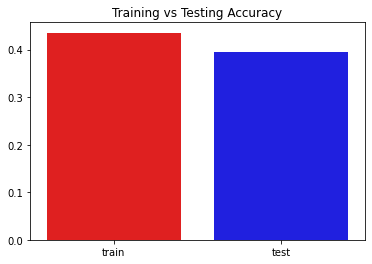

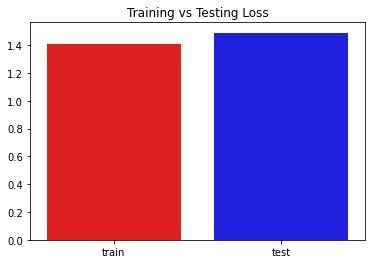


Classification Report
----------------------------
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       929
           1       0.33      0.30      0.31      1003
           2       0.36      0.26      0.30       900
           3       0.36      0.29      0.32       830
           4       0.37      0.37      0.37       741
           5       0.38      0.54      0.44       930

    accuracy                           0.39      5333
   macro avg       0.39      0.39      0.38      5333
weighted avg       0.39      0.39      0.39      5333


Confusion Matrix
----------------------------


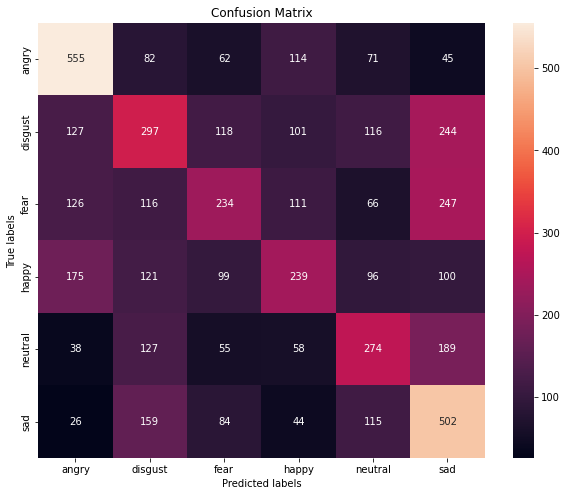

In [158]:
train_and_evaluate(CREMA_CFG)

# ALL

In [153]:
class ALL_CFG:
    ds = 'all'
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
    BASE_LR = 1e-4
    EPOCH = 20000
    BATCH_SIZE = 32
    model_name = 'simple_dense'
    preprocess = simple_dense_preprocess

    opt = get_opt('adamax', BASE_LR)
    es = get_es()
    lr = get_lr(factor=0.5, patience=3)
    loss = get_loss()

    callbacks = [
        es,
        lr
    ]
    
    def get_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
            
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Dense(len(ALL_CFG.classes), activation='softmax')
        ], name=f'{ALL_CFG.model_name}_{ALL_CFG.ds}')
        
        model.compile(loss=ALL_CFG.loss,
                     optimizer=ALL_CFG.opt,
                     metrics=['accuracy']
        )
        
        return model

Model: "simple_dense_all"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_109 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_34 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_111 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 6)            

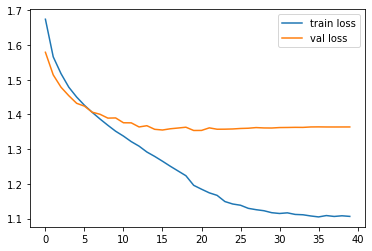

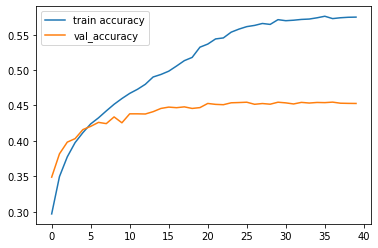


Evaluation
----------------------------
267/267 [==============================] - 1s 2ms/step - loss: 1.3596 - accuracy: 0.4518


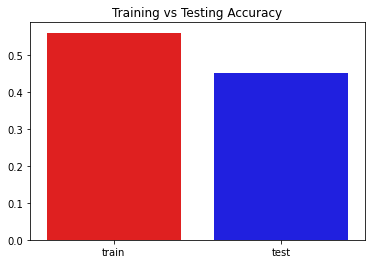

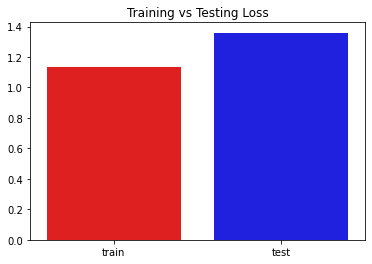


Classification Report
----------------------------
              precision    recall  f1-score   support

           0       0.53      0.60      0.56      1415
           1       0.40      0.44      0.42      1569
           2       0.45      0.35      0.39      1342
           3       0.41      0.31      0.36      1317
           4       0.45      0.57      0.50      1406
           5       0.46      0.43      0.44      1482

    accuracy                           0.45      8531
   macro avg       0.45      0.45      0.45      8531
weighted avg       0.45      0.45      0.45      8531


Confusion Matrix
----------------------------


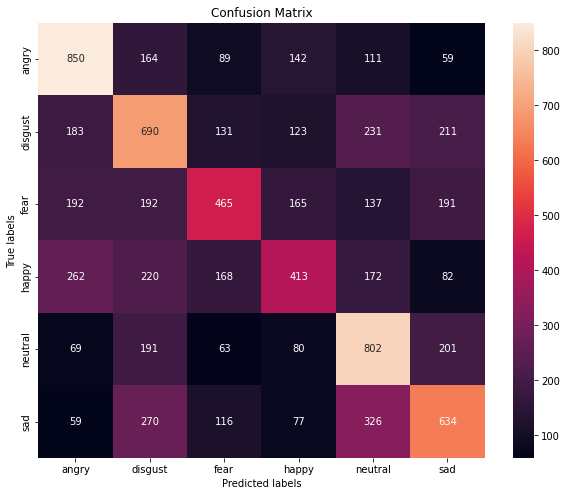

In [154]:
train_and_evaluate(ALL_CFG)